In [31]:
import numpy as np
from torch.utils.data import Dataset, dataloader
import matplotlib.pyplot as plt

In [32]:
N_samples = 3000
dimension = 2
std = 0.3

shift = 4
X_train = std * np.random.randn(N_samples, dimension) + shift

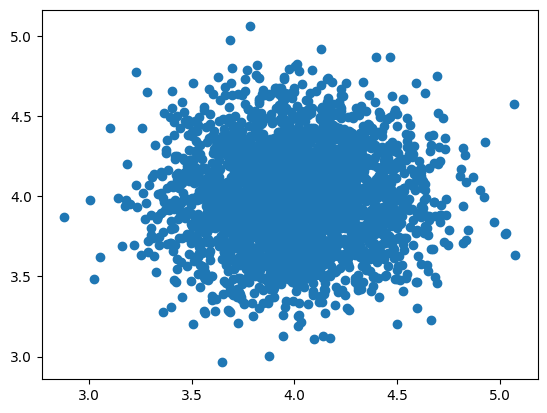

In [34]:
plt.scatter(X_train[:, 0], X_train[:, 1])
plt.show()

### Datasets


In [35]:
class TargetDataset(Dataset):
    def __init__(self, X):
        self.X = X
        self.N_samples = X.shape[0]
        self.dimension = X.shape[1]

    def __len__(self):
        return self.N_samples

    def __getitem__(self, idx):
        return self.X[idx, :]


class DiffusionDataset(Dataset):
    def __init__(self, target_ds, T):
        self.target_ds = target_ds
        self.T = T

    def __len__(self):
        return self.target_ds.__len__()

    def sampler(self, t, x0):
        coeff1 = np.exp(-t)
        coeff2 = np.sqrt(1 - np.exp(-2 * t))
        z = np.random.randn(*x0.shape)
        xt = coeff1 * x0 + coeff2 * z
        return np.expand_dims(t, axis=0), xt, z / coeff2

    def __getitem__(self, idx):
        t = np.random.uniform(0, self.T)
        x0 = self.target_ds.__getitem__(idx)
        return self.sampler(t, x0)


target_ds = TargetDataset(X_train)
diff_ds = DiffusionDataset(target_ds, T=5)

### DataLoaders


In [36]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(np.array(samples)) for samples in transposed]


diff_dl = dataloader.DataLoader(
    diff_ds, batch_size=128, shuffle=True, collate_fn=numpy_collate
)

### Loss fn


In [37]:
import torch
import torch.nn.functional as F


def loss_fn(model, t, xt, pred):
    out = model(t, xt).squeeze()
    return F.mse_loss(out, -pred.squeeze())

### Model


In [38]:
import torch
import torch.nn as nn


class ScoreNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ScoreNetwork, self).__init__()
        self.mlpt = nn.Sequential(
            nn.Linear(1, 16), nn.ReLU(), nn.Linear(16, 16), nn.ReLU()
        )
        self.mlpx = nn.Sequential(
            nn.Linear(input_dim, 16), nn.ReLU(), nn.Linear(16, 16), nn.ReLU()
        )
        self.mlpconcat = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
        )

    def forward(self, t, x):
        outt = self.mlpt(t)
        outx = self.mlpx(x)
        concatenated = torch.cat((outt, outx), dim=-1)
        return self.mlpconcat(concatenated)

### Sampling


In [19]:
# class Sampler:
#     def __init__(self, diff_ds, gamma, predictor_step):
#         self.diff_ds = diff_ds
#         self.gamma = gamma
#         self.predictor_step = predictor_step

#     def EulerMaruyamaSampler(self, model, y0, log_freq=0.1):
#         gamma = self.gamma
#         T = self.diff_ds.T
#         N_langevin = int(T / gamma)
#         N_log = int(log_freq * N_langevin)
#         y = y0
#         t = torch.zeros(y0.size(0), 1) + T

#         gamma_tensor = torch.tensor(gamma)  # Convert gamma to a tensor
#         out_list = [[t.clone(), y.clone()]]

#         for k in range(N_langevin):
#             t -= gamma_tensor
#             z = torch.randn_like(y)
#             y = (
#                 y
#                 + gamma_tensor * y
#                 + 2 * gamma_tensor * model(t, y)
#                 + torch.sqrt(2 * gamma_tensor) * z
#             )
#             for _ in range(self.predictor_step):
#                 z = torch.randn_like(y)
#                 y = y + gamma_tensor * model(t, y) + torch.sqrt(2 * gamma_tensor) * z
#             if k % N_log == 0:
#                 out_list.append([t.clone(), y.clone()])
#         out_list.append([t.clone(), y.clone()])

#         out_list_transposed = list(zip(*out_list))
#         return (
#             N_langevin,
#             torch.stack(out_list_transposed[0]),
#             torch.stack(out_list_transposed[1]),
#         )


# class Sampler:
#     def __init__(self, diff_ds, gamma, predictor_step):
#         self.diff_ds = diff_ds
#         self.gamma = gamma
#         self.predictor_step = predictor_step

#     def EulerMaruyamaSampling(
#         self, model, y0, log_freq=0.1, store_intermediate_samples=False
#     ):
#         gamma_tensor = torch.tensor(self.gamma)
#         T = self.diff_ds.T
#         N_langevin = int(T / self.gamma)
#         intermediate_samples = []

#         y = y0
#         t = torch.zeros(y0.size(0), 1) + T

#         for k in range(N_langevin):
#             t -= gamma_tensor
#             z = torch.randn_like(y)
#             y = (
#                 y
#                 + gamma_tensor * y
#                 + 2 * gamma_tensor * model(t, y)
#                 + torch.sqrt(2 * gamma_tensor) * z
#             )
#             for _ in range(self.predictor_step):
#                 z = torch.randn_like(y)
#                 y = y + gamma_tensor * model(t, y) + torch.sqrt(2 * gamma_tensor) * z
#             if store_intermediate_samples and (k % int(N_langevin / log_freq) == 0):
#                 intermediate_samples.append(y.clone().detach())

#         if store_intermediate_samples:
#             return intermediate_samples
#         else:
#             return y

In [39]:
class Sampler:
    def __init__(self, diff_ds, gamma, predictor_step, step_size=None):
        self.diff_ds = diff_ds
        self.gamma = gamma
        self.predictor_step = predictor_step
        self.step_size = step_size if step_size is not None else gamma

    # def EulerMaruyamaSampling(self, model, y0, store_intermediate_samples=False):
    #     gamma_tensor = torch.tensor(self.gamma)
    #     intermediate_samples = []
    #     y = y0

    #     for k in range(int(self.diff_ds.T / self.gamma)):
    #         noise = torch.randn_like(y)
    #         y = y + gamma_tensor * model(y) + torch.sqrt(2 * gamma_tensor) * noise
    #         if store_intermediate_samples:
    #             intermediate_samples.append(y.clone().detach())

    #     return intermediate_samples if store_intermediate_samples else y

    def EulerMaruyamaSampling(
        self, model, y0, log_freq=0.1, store_intermediate_samples=False
    ):
        gamma_tensor = torch.tensor(self.gamma)
        T = self.diff_ds.T
        N_langevin = int(T / self.gamma)
        intermediate_samples = []

        y = y0
        t = torch.zeros(y0.size(0), 1) + T

        for k in range(N_langevin):
            t -= gamma_tensor
            z = torch.randn_like(y)
            y = (
                y
                + gamma_tensor * y
                + 2 * gamma_tensor * model(t, y)
                + torch.sqrt(2 * gamma_tensor) * z
            )
            for _ in range(self.predictor_step):
                z = torch.randn_like(y)
                y = y + gamma_tensor * model(t, y) + torch.sqrt(2 * gamma_tensor) * z
            if store_intermediate_samples and (k % int(N_langevin / log_freq) == 0):
                intermediate_samples.append(y.clone().detach())

        if store_intermediate_samples:
            return intermediate_samples
        else:
            return y

    def LangevinDynamicsSampling(self, model, y0, store_intermediate_samples=False):
        intermediate_samples = []
        y = y0

        for k in range(int(self.diff_ds.T / self.gamma)):
            for _ in range(self.predictor_step):
                noise = torch.randn_like(y)
                gradient = model(y)
                y = (
                    y
                    - 0.5 * self.step_size * gradient
                    + torch.sqrt(self.step_size) * noise
                )
            if store_intermediate_samples:
                intermediate_samples.append(y.clone().detach())

        return intermediate_samples if store_intermediate_samples else y

    def RK4Sampling(self, model, y0, store_intermediate_samples=False):
        gamma_tensor = torch.tensor(self.gamma)
        intermediate_samples = []
        y = y0

        for k in range(int(self.diff_ds.T / self.gamma)):
            k1 = self.gamma * model(y)
            k2 = self.gamma * model(y + 0.5 * k1)
            k3 = self.gamma * model(y + 0.5 * k2)
            k4 = self.gamma * model(y + k3)
            y = y + (k1 + 2 * k2 + 2 * k3 + k4) / 6
            if store_intermediate_samples:
                intermediate_samples.append(y.clone().detach())

        return intermediate_samples if store_intermediate_samples else y

### Training


In [40]:
def plot_samples(samples, epoch, show=True, save=False, path=""):
    plt.figure(figsize=(6, 6))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
    plt.title(f"Samples at Epoch {epoch}")
    if save:
        plt.savefig(f"{path}/epoch_{epoch}.png")
    if show:
        plt.show()
    plt.close()

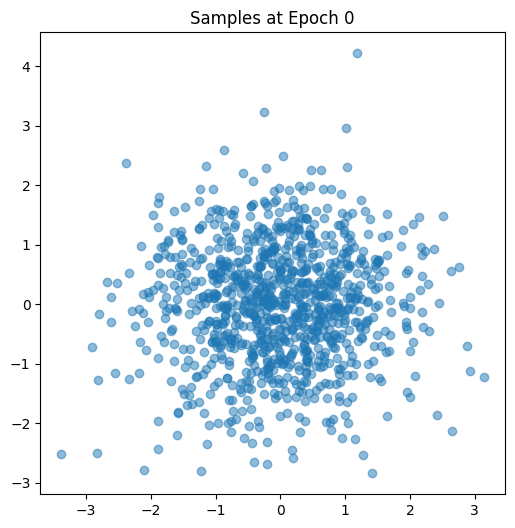

Epoch 0, Loss value: 1.3857725858688354


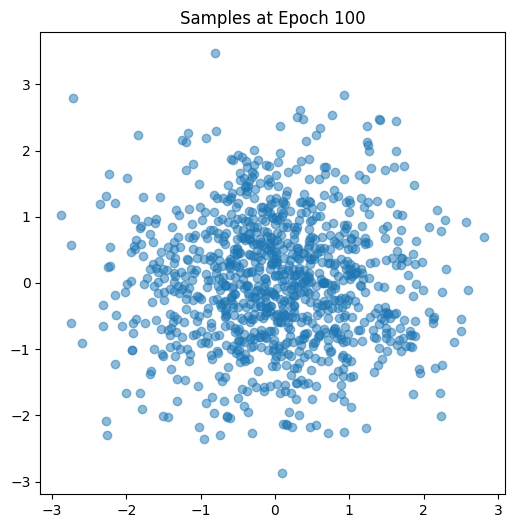

Epoch 100, Loss value: 0.40428581833839417


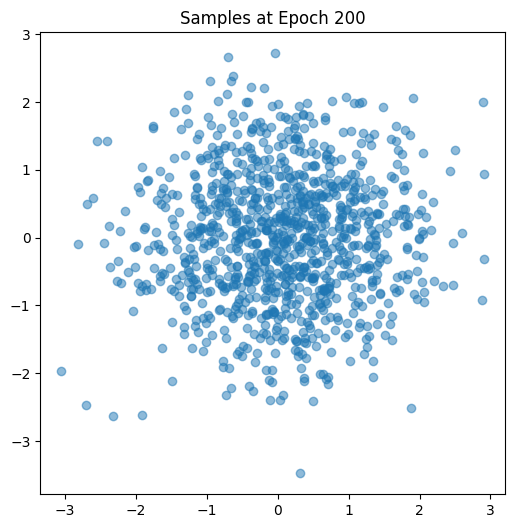

Epoch 200, Loss value: 1.3541858196258545


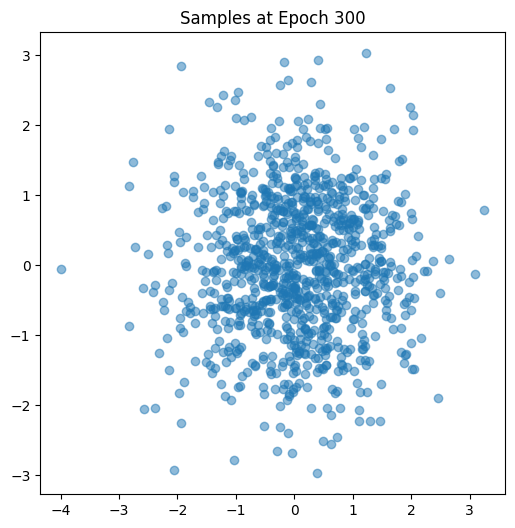

Epoch 300, Loss value: 0.1242092028260231


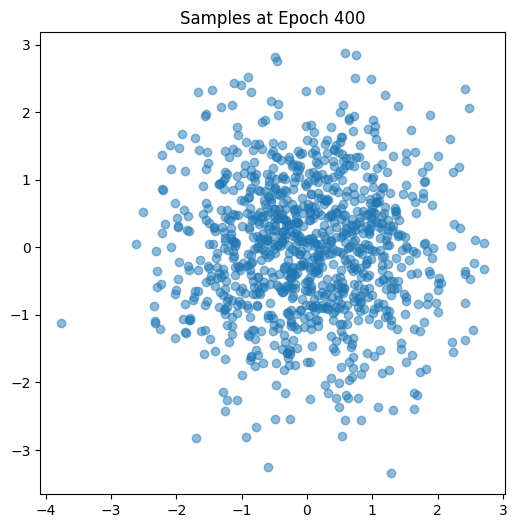

Epoch 400, Loss value: 0.15621575713157654


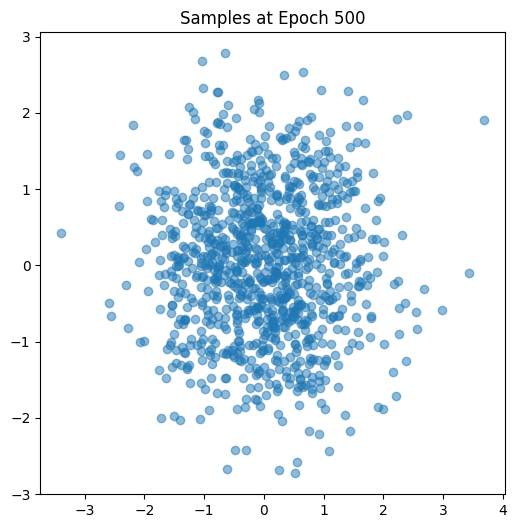

Epoch 500, Loss value: 0.03637007996439934


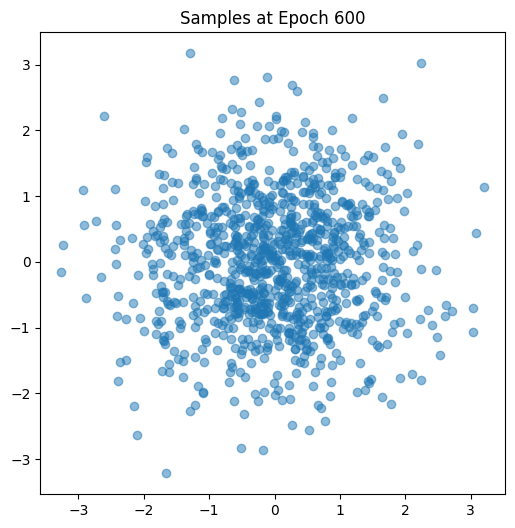

Epoch 600, Loss value: 11.81497859954834


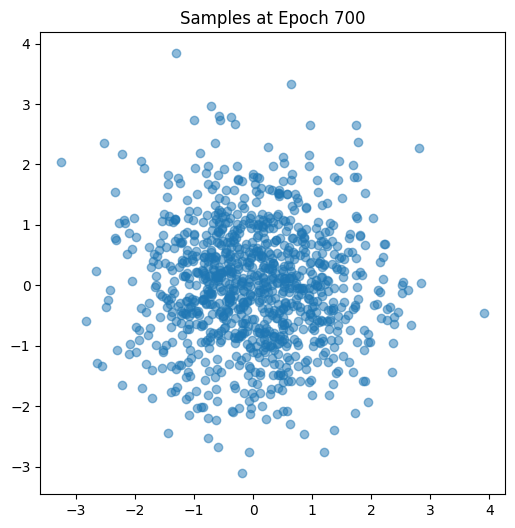

Epoch 700, Loss value: 0.11156965792179108


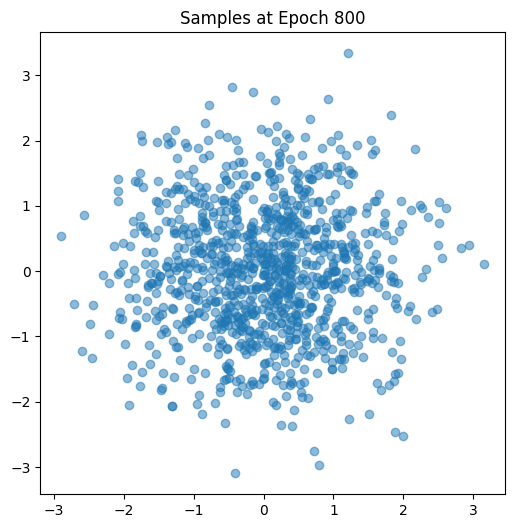

Epoch 800, Loss value: 0.7427838444709778


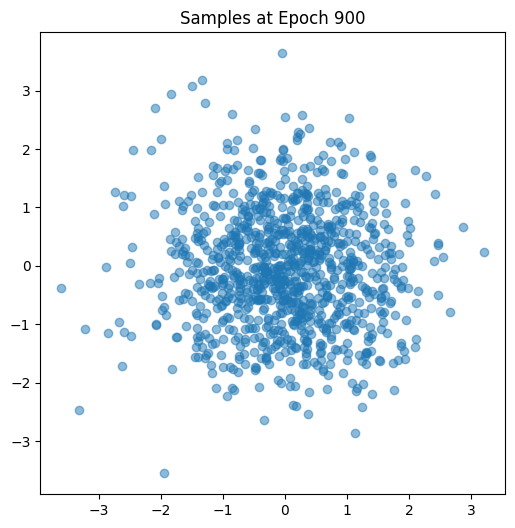

Epoch 900, Loss value: 0.15937818586826324


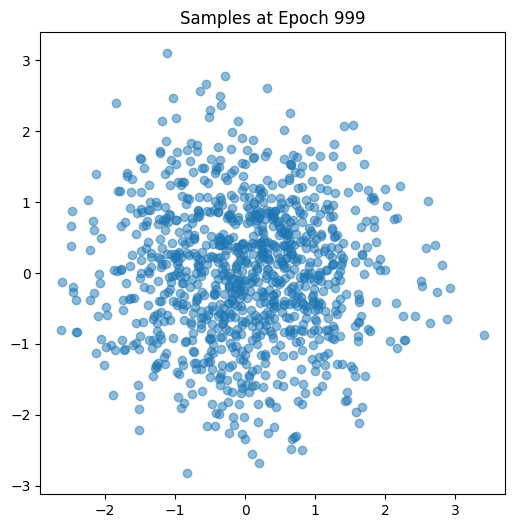

Epoch 999, Loss value: 5.589620113372803


In [41]:
# Training setup
gamma = 1e-3
predictor_step = 3
sampler = Sampler(diff_ds, gamma, predictor_step)
N_samples_test = 1000

model = ScoreNetwork(input_dim=dimension)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
nepoch = 1000
visualize_epoch = 100  # Epoch interval for visualization

for n in range(nepoch):
    for t, xt, pred in diff_dl:
        t = torch.tensor(t, dtype=torch.float32)
        xt = torch.tensor(xt, dtype=torch.float32)
        pred = torch.tensor(pred, dtype=torch.float32)

        optimizer.zero_grad()
        loss = loss_fn(model, t, xt, pred)

        loss.backward()
        optimizer.step()

    # Visualization at specific epochs
    if n % visualize_epoch == 0 or n == nepoch - 1:
        with torch.no_grad():
            y0 = torch.randn(N_samples_test, dimension)
            store_intermediate_samples = True
            intermediate_samples = sampler.EulerMaruyamaSampling(
                model, y0, store_intermediate_samples=store_intermediate_samples
            )

            interval = nepoch // len(intermediate_samples)

            for idx, samples in enumerate(intermediate_samples):
                epoch_title = n - (len(intermediate_samples) - 1 - idx) * interval
                plot_samples(samples.numpy(), epoch_title)

        print(f"Epoch {n}, Loss value: {loss.item()}")

In [52]:
N_samples_test = 1000
gamma = 1e-3
predictor_step = 3

# Generating data with the Euler-Maruyama sampler
y0 = torch.randn(N_samples_test, dimension)
sampler = Sampler(diff_ds, gamma, predictor_step)
# Nlangevin, outt, outy = sampler.EulerMaruyamaSampling(model, y0)

gen_samples = sampler.EulerMaruyamaSampling(model, y0)

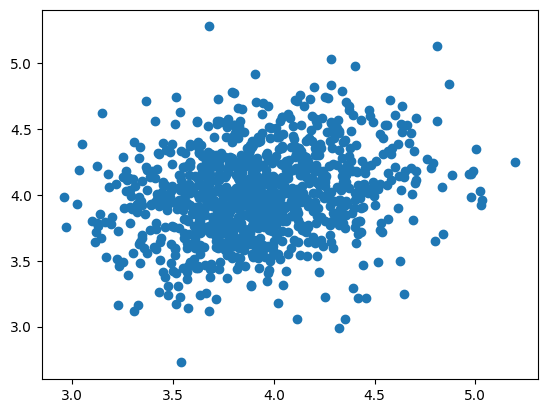

In [51]:
# Visualization of the final sampling step
plt.scatter(gen_samples[:, 0].detach().numpy(), gen_samples[:, 1].detach().numpy())
plt.show()